# CycleGAN

The CycleGAN architecture is proposed by Zhu et al. in 2020. In CycleGAN, instead of generating images, it aims to perform image translation tasks (for example, turning horses into zebras, grayscale images into colored images, summer scenes into winter scenes, etc.).<br>

Formally, let $\mathcal{X}$ and $\mathcal{Y}$ denote two image domains. We want to learn a mapping $F: \mathcal{X} \rightarrow \mathcal{Y}$. This turns images in the source domain $\mathcal{X}$ into images in the target domain $\mathcal{Y}$. However, there are many different ways to map $X \in \mathcal{X}$ to $Y \in \mathcal{Y}$. To constrain the problem, we also learn the inverse mapping $G: \mathcal{Y} \rightarrow \mathcal{X}$ and impose the cycle consistency constraint

$$G(F(X))=X\hspace{10mm}F(G(Y))=Y$$

In CycleGAN, the mappings $F$ and $G$ are parameterized as two GANs:

* $F$ is responsible to converting image in space $\mathcal{X}$ to image in space $\mathcal{Y}$
* $G$ is responsible to converting image in space $\mathcal{Y}$ to image in space $\mathcal{X}$
* The discriminator for $F$, denoted as $D_F$, attempts to detect images generated by $G$
* The discriminator for $G$, denoted as $D_G$, attempts to detect images generated by $F$

The objective is the combined adversarial loss for the two GANs. 

$$\mathcal{L}(F, G, D_F, D_G) = \mathbb{E}_{x\sim p(x)}[\log (1-D_F(G(x)))]+\mathbb{E}_{y\sim p(y)}[\log D_F(y)]+ \mathbb{E}_{x\sim p(x)}[\log (1-D_G(F(x)))]+\mathbb{E}_{y\sim p(y)}[\log D_G(y)]$$

Intuitively, we want the mapping $F$ to be able to fool the discriminator $D_G$, so that it maps $X$ to a realistic image $Y$. At the same time, we also want discriminator $D_G$ to be a challenging opponent! The same reasoning applies to the other side.

## Cycle consistency loss

As mentioned before, to constrain the problem, we impose the cycle consistency contraint, which restricts that

$$G(F(X))=X\hspace{10mm}F(G(Y))=Y$$

The loss associated to this constraint is given by

$$\mathcal{L}_{cycle}(F, G) = \mathbb{E}_{x\sim p(x)}[\|G(F(x))-x\|_1] + \mathbb{E}_{y\sim p(y)}[\|F(G(y))-y\|_1]$$

In the paper, $L_1$ norm is used since $L_2$ norm tend to create blurry images.

## Identity loss

In the paper, the authors added an additional loss: the identity loss. The intuition is that applying $F$ to images in domain $\mathcal{Y}$ should just be itself, since $F$ is supposed to turn images in $\mathcal{X}$ to $\mathcal{Y}$. So essentially we are imposing the constraint that $F$ is an identity map on $\mathcal{Y}$. The same applies for $G$. Formally, the identity loss is given by 

$$\mathcal{L}_{identity}(F, G) = \mathbb{E}_{x\sim p(x)}[\|G(x)-x\|_1] + \mathbb{E}_{y\sim p(y)}[\|F(y)-y\|_1]$$

## Combined loss

Finally, the combined loss is CycleGAN is given by

$$\mathcal{L}({F, G, D_F, D_G}) = \mathcal{L}(F, G, D_F, D_G) + \lambda_{cycle}\mathcal{L}_{cycle}(F, G) + \lambda_{identity}\mathcal{L}_{identity}(F, G) $$

Where $\lambda_{cycle}, \lambda_{identity}$ are two hyperparameters that controls the impact of consistency and identity loss. The optimization problem is therefore to solve

$$F^*, G^* = \underset{F, G}{\text{argmin}}\max_{D_F, D_G}\;\mathcal{L}({F, G, D_F, D_G})$$

## CycleGAN implementation

Below we implement CycleGAN and test its performance on MNIST/colored MNIST image translation dataset. The dataset is shown below. 

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split
from cycleGAN import *
import cv2

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

grayscale_mnist, color_mnist = load_mnist('./mnist_data.npy', './cmnist_data.npy')
dataset = GrayscaleAndColoredMNIST(grayscale_mnist, color_mnist)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Generator/Discriminator implementation

We start by implementing the generator/discriminator. We follow a CNN architecture for both generator and discrimintator. The architecture is shown below. We speicifically make the generator strongfer by allowing multiple convolutional block layers. 

In [6]:
class Generator(nn.Module):
    def __init__(self, n_layers):
        super(Generator, self).__init__()
        self.net = [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3),
                    nn.InstanceNorm2d(num_features=64),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
                    nn.InstanceNorm2d(num_features=128),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
                    nn.InstanceNorm2d(num_features=256),
                    nn.ReLU()]  ## [1, 256, 8, 8]
        for _ in range(n_layers):
            self.net.append(ResnetBlock(in_channels=256, out_channels=256))
        self.net.extend([nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
                         nn.ReLU(),
                         nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
                         nn.ReLU(),
                         nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=3),
                         nn.Tanh()])
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
                                 nn.InstanceNorm2d(num_features=64),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
                                 nn.InstanceNorm2d(num_features=128),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
                                 nn.InstanceNorm2d(num_features=256),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
                                 nn.InstanceNorm2d(num_features=512),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=1))

    def forward(self, x):
        ## in: [B, 3, 32, 32]
        ## out: [B, 1]
        x = self.net(x).view(x.shape[0], -1)
        return x

class GAN(nn.Module):
    def __init__(self, n_layers):
        super(GAN, self).__init__()
        self.generator = Generator(n_layers)
        self.discriminator = Discriminator()

In [7]:
def train_epoch(model_g, model_c, train_loader, test_loader, optimizer_disc, optimizer_gen, criterion, lambda_cycle, lambda_identity, sample=True, device="cpu"):
    model_g.train()
    model_c.train()
    model_g.to(device)
    model_c.to(device)
    train_loss = 0.0
    for i, (x_g, x_c) in enumerate(train_loader):
        x_g, x_c = x_g.float().to(device), x_c.float().to(device)

        batch_size = x_g.size(0)

        ## Train Discriminator 
        optimizer_disc.zero_grad()

        ## Discriminator loss for grayscale
        loss_g_real_disc = criterion(model_g.discriminator(x_g), torch.ones(batch_size, 1).to(device))
        loss_g_fake_disc = criterion(model_g.discriminator(model_g.generator(x_c)), torch.zeros(batch_size, 1).to(device))

        ## Discriminator loss for color
        loss_c_real_disc = criterion(model_c.discriminator(x_c), torch.ones(batch_size, 1).to(device))
        loss_c_fake_disc = criterion(model_c.discriminator(model_c.generator(x_g)), torch.zeros(batch_size, 1).to(device))

        ## Compute discriminator loss
        loss_disc = (loss_g_real_disc + loss_g_fake_disc + loss_c_real_disc + loss_c_fake_disc) / 4
        loss_disc.backward()
        optimizer_disc.step()
  
        ## Train Generator
        optimizer_gen.zero_grad()

        ## Generator loss
        loss_g_fake_gen = criterion(model_g.discriminator(model_g.generator(x_c)), torch.ones(batch_size, 1).to(device))
        loss_c_fake_gen = criterion(model_c.discriminator(model_c.generator(x_g)), torch.ones(batch_size, 1).to(device))

        ## Cycle consistency loss
        loss_cycle_g = F.l1_loss(x_g, model_g.generator(model_c.generator(x_g)))
        loss_cycle_c = F.l1_loss(x_c, model_c.generator(model_g.generator(x_c)))

        ## Identity loss
        loss_identity_g = F.l1_loss(x_g, model_g.generator(x_g))
        loss_identity_c = F.l1_loss(x_c, model_c.generator(x_c))

        loss_gen = (loss_g_fake_gen + loss_c_fake_gen) + lambda_cycle * (loss_cycle_g + loss_cycle_c) + lambda_identity * (loss_identity_g + loss_identity_c)
        loss_gen.backward()
        optimizer_gen.step()
        train_loss += loss_disc.item() + loss_gen.item()
    return train_loss

We train the model for $10$ epochs. 

In [8]:
model_g = GAN(n_layers=1)
model_c = GAN(n_layers=1)
lambda_cycle = 10
lambda_identity = 10
n_epochs=10
criterion = nn.BCEWithLogitsLoss()
optimizer_disc = optim.Adam(list(model_g.discriminator.parameters()) + list(model_c.discriminator.parameters()), lr=1e-3, betas=(0.5, 0.999))
optimizer_gen = optim.Adam(list(model_g.generator.parameters()) + list(model_c.generator.parameters()), lr=1e-3, betas=(0.5, 0.999))
train(n_epochs, model_g, model_c, train_loader, test_loader, optimizer_disc, optimizer_gen, criterion, lambda_cycle, lambda_identity, device=DEVICE)

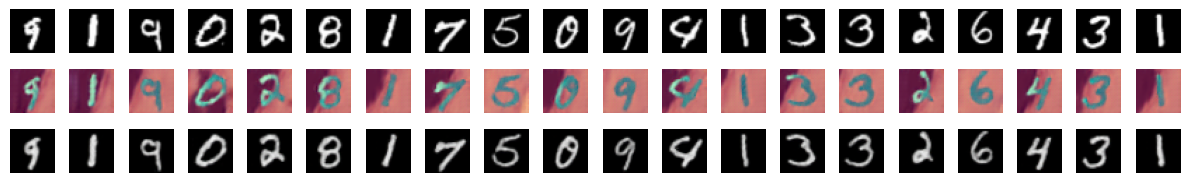

In [24]:
plot_grayscale_to_color(model_g, model_c, test_loader, device=DEVICE)

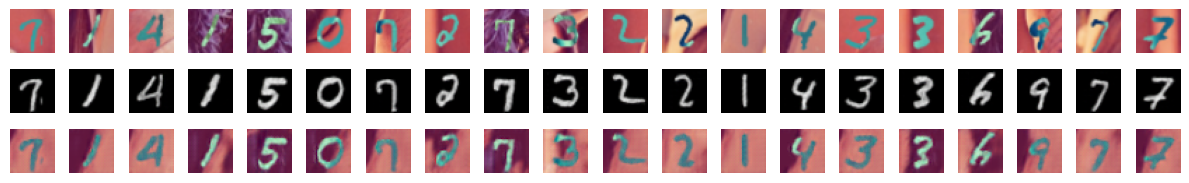

In [23]:
plot_color_to_grayscale(model_g, model_c, test_loader, device=DEVICE)